In [1]:
import numpy as np
import netCDF4 as nc
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import warnings
import multiprocessing
import ctypes as c
from datetime import datetime, time, timedelta
from scipy.interpolate import interp1d
from optparse import OptionParser
from tqdm import tnrange, notebook
from time import sleep
import xarray as xr
from contextlib import contextmanager
from scipy.spatial import cKDTree
from functools import partial
from matplotlib import rc
import time
import os

In [2]:
###### SET FILE NAMES AND CONSTANTS ######
dates = ("2020050300","2020070700","2020081006","2021052612")
utc = 18  # Initailization Time
ng = 3  # Number of groups to compare (e.g., WRF & FV3)
ne = 1  # Number of ensemble members in each group of files
fstarts = np.array(( 16, 2, 10, 9)) #16  # Forecast time start
fends = np.array(( 21, 7, 15, 14)) #21    # Forecast time end
nfs = fends - fstarts + 1
nth = 1

group_names = ('HRRR' ,'NORD3', 'CTRL','GridRad')  # Name of the groups to compare
group_names_label = ('HRRR' ,'NORD3', 'NORD2','GridRad')
top_dir = "/work/larissa.reames"
#case_dir = "%s/%s"%(top_dir,date)
filter_top_dir = "/work/wicker/CAM_case_studies"
#filter_case_dir = "%s/%s"%(filter_top_dir,date)

#filter_file_names = ''
#fcst_type = 0
ens = 0
filter_lvls = [0,12,8]
#wths = [5.0,7.5]
#dbzths = [45.0,55.0]
dbzth = 99.0

In [7]:
z_interp = np.arange(0.0,15000.0,250.0)
nz = z_interp.shape[0]
nf = 6
nflt = 1
obj_sizes=np.full((6,ng,nth,nf,200),np.nan)
obj_counts=np.full((6,ng,nth,nf),np.nan)
for d, date in enumerate(dates):
    case_dir = "%s/%s"%(top_dir,date)
    filter_case_dir = "%s/%s"%(filter_top_dir,date)
    fstart = fstarts[d]
    fend = fends[d]
    for g in np.arange(ng):
        obj_x=np.full((nth,nf,200,200),np.nan)
        obj_y=np.full((nth,nf,200,200),np.nan)
        for th in np.arange(nth):
            updraft_file_name = "%s/%s_%s_track_data_noth_cref%2.1f.nc"%(case_dir,date,group_names[g].lower(),dbzth)
            fobj = xr.open_dataset(updraft_file_name)
            obj_x[th,:] = fobj.OBJ_LOCS_X[:,:200,:200] #oth,time,obj,obj-point
            obj_y[th,:] = fobj.OBJ_LOCS_Y[:,:200,:200]
            obj_sizes[d,g,th,:] = (np.array(fobj.OBJ_SIZES[:,:200]))
            obj_counts[d,g,th,:] = (np.array(fobj.OBJ_COUNTS))

        obj_x = np.array(obj_x)
        obj_y = np.array(obj_y)
        for j,fl in enumerate(filter_lvls):
            print("Begin reading in data for group %s" % group_names[g])
            if (j > 0):
                #stream = os.popen("seq -f "+filter_case_dir+"/"+group_names[g].lower()+"/W_%02d"%(fl)+"/filtered_*_F%02g.nc"+" %02d %02d"%(fstart,fend))
                fs = glob.glob('%s/%s/W_%02d/filtered*.nc'%(filter_case_dir,group_names[g].lower(),fl))
            else:
                #stream = os.popen("seq -f "+case_dir+"/"+group_names[g].lower()+"/econus_"+date+"00_F%02g.nc"+" %02d %02d"%(fstart,fend))
                string = '%s/%s/econus*.nc'%(case_dir,group_names[g].lower())
                print(string)
                fs = glob.glob(string)
            #fs = []
            #for line in stream.readlines() :
            #    fs.append(line.strip())
            fs.sort()
            print(fs)
            for n,fname in enumerate(fs):
                print(fname)
                f = xr.open_dataset(fname)
                w = f.variables['REFL_10CM']
                if (g < 3):
                    z = f.variables['GPH']-f.variables['HGT']
                else:
                    z = f.variables['height']
                    
                nz_cur,_,_ = np.shape(w)
                if (d==0 and n == 0 and j==0 and g==0):
                    w_objs = np.full((6,ng,nth,nflt,nf,200,200,nz),np.nan)
                    #obj_sizes = np.full((nf,3,nf,500),np.nan)

                for th in np.arange(nth):
                    obj_x_cur = np.where(obj_x[th,n,...]<0,np.nan, obj_x[th,n,...])
                    obj_y_cur = np.where(obj_y[th,n,...]<0,np.nan, obj_y[th,n,...])
                    nobj = np.sum((~np.isnan(obj_x_cur[:,0])).astype(int))
                    for i in np.arange(nobj):
                        obj_size = np.sum((~np.isnan(obj_x_cur[i,:])).astype(int))
                        w_interp = np.full(nz,0.0)
                        for p in np.arange(obj_size):
                            y = obj_y_cur[i,p].astype(int)
                            x = obj_x_cur[i,p].astype(int)
                            if (g < 3):
                                z_cur = z[:,y,x]
                            else :
                                z_cur = z
                                
                            w_cur = w[:,y,x]
                            w_objs[d,g,th,j,n,i,p,:] = np.interp(z_interp,z_cur,w_cur )
    

Begin reading in data for group HRRR
/work/larissa.reames/2020050300/hrrr/econus*.nc
['/work/larissa.reames/2020050300/hrrr/econus_202005030000_F16.nc', '/work/larissa.reames/2020050300/hrrr/econus_202005030000_F17.nc', '/work/larissa.reames/2020050300/hrrr/econus_202005030000_F18.nc', '/work/larissa.reames/2020050300/hrrr/econus_202005030000_F19.nc', '/work/larissa.reames/2020050300/hrrr/econus_202005030000_F20.nc', '/work/larissa.reames/2020050300/hrrr/econus_202005030000_F21.nc']
/work/larissa.reames/2020050300/hrrr/econus_202005030000_F16.nc


KeyError: 'REFL_10CM'

In [37]:
w_objs_save = np.ndarray.copy(w_objs)
obj_sizes_save = np.ndarray.copy(obj_sizes)
obj_counts_save = np.ndarray.copy(obj_counts)

#w_objs = w_objs_save
#obj_sizes = obj_sizes_save
#obj_counts = obj_counts_save


In [7]:
outfilename = ("%s/alldates_objects_w_noth_%2.1f_%02d.nc"%(top_dir,wth,dbzth))
new = xr.DataArray( w_objs, dims=['date','group','objthresh','filter','time','n_obj_max','obj_size_max','z'], 
                     coords={"dates": (["date"], np.arange(6)),
                             "groups": (["group"], np.arange(ng)),
                             "threshes": (["objthresh"], np.arange(2)),
                             "filters": (["filter"], filter_lvls),
                             "times": (["time"], np.arange(1,7)),
                             "obj": (["n_obj_max"], np.arange(200)) ,
                             "point": (["obj_size_max"], np.arange(200)),
                             "height": (["z"], z_interp),} )
ds_conus = new.to_dataset(name = 'W_OBJS')

# Add attributes

ds_conus.attrs['gridType']   = 'conus'
ds_conus.attrs['DateTime']   = datetime.now().strftime("%Y%m%d_%H:%M:%S")
ds_conus.attrs['TimeStamp']  = datetime.timestamp(datetime.now())

ds_conus.to_netcdf(outfilename, mode='w') 

In [4]:
#f = xr.open_dataset(outfilename)
#w_objs = f.W_OBJS
w_objs_2plus = np.ndarray.copy(w_objs)
w_objs_3plus = np.ndarray.copy(w_objs)
obj_sizes_2plus = np.ndarray.copy(obj_sizes)
obj_sizes_3plus = np.ndarray.copy(obj_sizes)
obj_counts_2plus = np.ndarray.copy(obj_counts)
obj_counts_3plus = np.ndarray.copy(obj_counts)
for d in np.arange(6):
    for g in np.arange(4):
        for th in np.arange(2):
            for t in np.arange(6):
                np.where(obj_sizes_2plus[d,g,th,t,:]<2,np.nan,obj_sizes_2plus[d,g,th,t,:])
                np.where(obj_sizes_3plus[d,g,th,t,:]<3,np.nan,obj_sizes_3plus[d,g,th,t,:])
                nlt2 = np.count_nonzero(obj_sizes_2plus[d,g,th,t,:]<2)
                nlt3 = np.count_nonzero(obj_sizes_2plus[d,g,th,t,:]<3)
                print(nlt2,nlt3)
                obj_counts_2plus[d,g,th,t] -= nlt2 
                obj_counts_3plus[d,g,th,t] -= nlt3
                print(obj_counts[d,g,th,t],obj_counts_2plus[d,g,th,t],obj_counts_3plus[d,g,th,t])
                no = np.count_nonzero(~np.isnan(w_objs_2plus[d,g,th,0,t,:,0,0]))
                print(no)
                for i in np.arange(no):
                    sz = np.count_nonzero(~np.isnan(w_objs_2plus[d,g,th,0,t,i,:,0]))   
                    if (sz < 2): 
                        w_objs_2plus[d,g,th,:,t,i,:,:] = np.nan
                        w_objs_3plus[d,g,th,:,t,i,:,:] = np.nan
                        print("size less than 2 ", sz)
                        print('34', w_objs[d,g,th,0,t,i,0,20],w_objs_2plus[d,g,th,0,t,i,0,20],w_objs_3plus[d,g,th,0,t,i,0,20])
                    elif (sz < 3): 
                        w_objs_3plus[d,g,th,:,t,i,:,:] = np.nan
                        print("size less than 3 ", sz)
                        print('38', w_objs[d,g,th,0,t,i,0,20],w_objs_2plus[d,g,th,0,t,i,0,20],w_objs_3plus[d,g,th,0,t,i,0,20])
                        
                    

7 14
25.0 18.0 11.0
25
size less than 2  1
34 5.442319099866824 nan nan
size less than 2  1
34 2.3853176393759545 nan nan
size less than 3  2
38 3.009550582868894 3.009550582868894 nan
size less than 3  2
38 4.1155427711308725 4.1155427711308725 nan
size less than 3  2
38 6.44957870145191 6.44957870145191 nan
size less than 3  2
38 7.030852855158807 7.030852855158807 nan
size less than 2  1
34 1.615658535414315 nan nan
size less than 2  1
34 2.2727274566237985 nan nan
size less than 2  1
34 6.06802074471222 nan nan
size less than 2  1
34 5.7390400739236425 nan nan
size less than 2  1
34 5.342735651277501 nan nan
size less than 3  2
38 2.645666972198784 2.645666972198784 nan
size less than 3  2
38 7.226355102349153 7.226355102349153 nan
size less than 3  2
38 4.298464261225619 4.298464261225619 nan
6 19
45.0 39.0 26.0
45
size less than 2  1
34 3.6659508695477623 nan nan
size less than 3  2
38 8.844835127232654 8.844835127232654 nan
size less than 3  2
38 3.0012428930429382 3.00124289304

size less than 2  1
34 4.915493117209096 nan nan
size less than 2  1
34 4.672172435339848 nan nan
size less than 3  2
38 3.2506046152532835 3.2506046152532835 nan
size less than 2  1
34 3.266145375001545 nan nan
size less than 2  1
34 4.550907423389604 nan nan
size less than 2  1
34 4.256599296929117 nan nan
size less than 2  1
34 5.229380771181552 nan nan
size less than 3  2
38 6.115709019463494 6.115709019463494 nan
size less than 3  2
38 2.794097867928387 2.794097867928387 nan
9 13
69.0 60.0 56.0
69
size less than 3  2
38 4.099909417825059 4.099909417825059 nan
size less than 2  1
34 3.157910375192119 nan nan
size less than 2  1
34 2.6195108120612653 nan nan
size less than 3  2
38 2.395639312955138 2.395639312955138 nan
size less than 3  2
38 4.416014926325422 4.416014926325422 nan
size less than 2  1
34 3.3075898007592235 nan nan
size less than 2  1
34 3.7828898552757035 nan nan
size less than 2  1
34 5.179332331779339 nan nan
size less than 2  1
34 2.417424431683136 nan nan
size l

IndexError: index 3 is out of bounds for axis 1 with size 3

<ipython-input-14-6b240ae98511>:11: RuntimeWarning: All-NaN slice encountered
  w_pts_plot = np.moveaxis(np.nanmax(w_objs_3plus[:,:,th,0,...].squeeze(),axis=5),0,-1) #group, time, obj, point,day
<ipython-input-14-6b240ae98511>:14: RuntimeWarning: Mean of empty slice
  w_obj_plot = np.moveaxis(np.nanmax(np.nanmean(w_objs_3plus[:,:,th,0,...].squeeze(),axis=4),axis=4),0,-1).reshape(ng,7200)
<ipython-input-14-6b240ae98511>:14: RuntimeWarning: All-NaN slice encountered
  w_obj_plot = np.moveaxis(np.nanmax(np.nanmean(w_objs_3plus[:,:,th,0,...].squeeze(),axis=4),axis=4),0,-1).reshape(ng,7200)


3940
1970
3631
1815
2806
1403


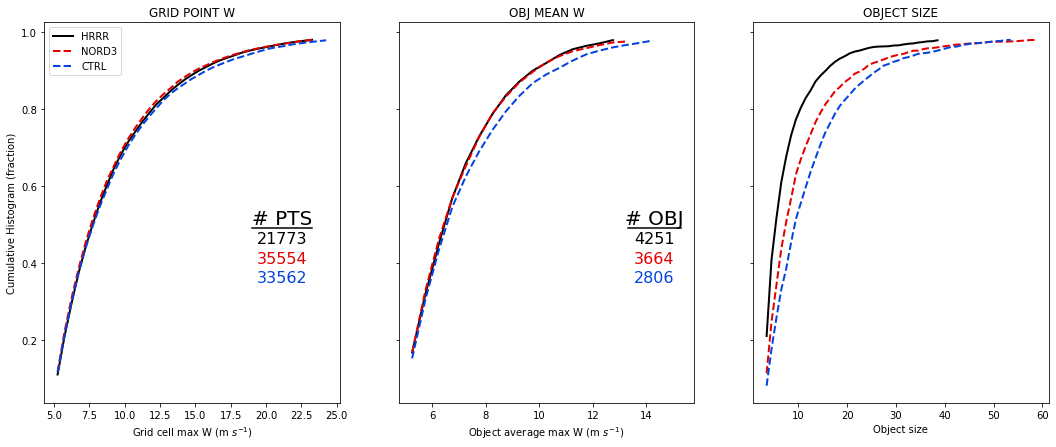

<ipython-input-14-6b240ae98511>:11: RuntimeWarning: All-NaN slice encountered
  w_pts_plot = np.moveaxis(np.nanmax(w_objs_3plus[:,:,th,0,...].squeeze(),axis=5),0,-1) #group, time, obj, point,day
<ipython-input-14-6b240ae98511>:14: RuntimeWarning: Mean of empty slice
  w_obj_plot = np.moveaxis(np.nanmax(np.nanmean(w_objs_3plus[:,:,th,0,...].squeeze(),axis=4),axis=4),0,-1).reshape(ng,7200)
<ipython-input-14-6b240ae98511>:14: RuntimeWarning: All-NaN slice encountered
  w_obj_plot = np.moveaxis(np.nanmax(np.nanmean(w_objs_3plus[:,:,th,0,...].squeeze(),axis=4),axis=4),0,-1).reshape(ng,7200)


1870
935
2202
1101
1778
889


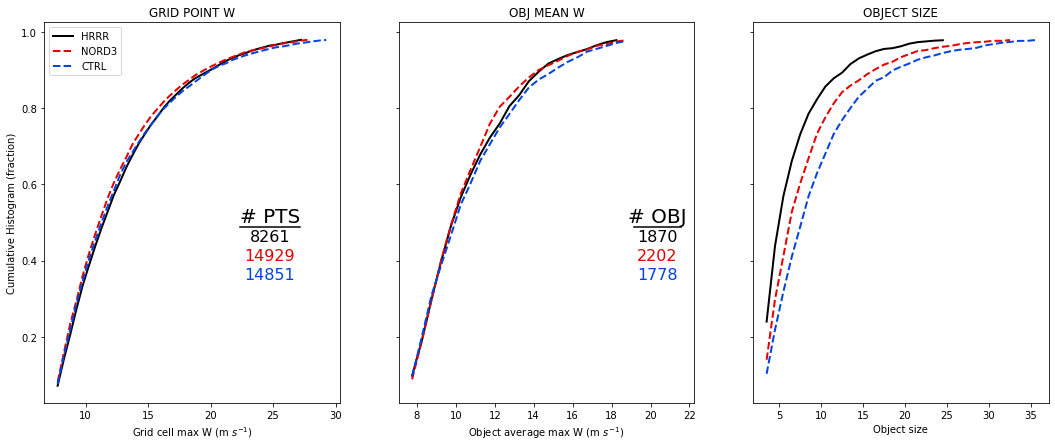

In [14]:


linecolors=("black","xkcd:red","xkcd:blue",)
linestyles=("-","--","--")
linewidths=(2,2,2,2)
#w_objs[f,g,oth,j,n,i,p,:] days, group, oth, filter, time, obj, point, z
w_pct = np.full((nth,ng,3),0.0)
for th in np.arange(nth):
    fig,ax = plt.subplots(1,3,sharey='row')
    fig.set_size_inches(18,7)
    wth = wths[th]
    dbzth = dbzths[th]
    w_pts_plot = np.moveaxis(np.nanmax(w_objs_3plus[:,:,th,0,...].squeeze(),axis=5),0,-1) #group, time, obj, point,day

    w_pts_plot = w_pts_plot.reshape((ng,1440000))
    w_obj_plot = np.moveaxis(np.nanmax(np.nanmean(w_objs_3plus[:,:,th,0,...].squeeze(),axis=4),axis=4),0,-1).reshape(ng,7200)

    edges = np.arange(wth,55.0,0.5)
    edges_size = np.arange(3,200,1)
    obj_size_plot = np.moveaxis(obj_sizes_3plus[:,:,th,:,:],0,-1).reshape((ng,7200))
    for g in np.arange(ng):
        print(np.sum((~np.isnan(w_obj_plot[g,:])).astype(int)))
        w_pct[th,g,:] = np.nanpercentile(w_obj_plot[g,:],(50,75,90))
        print(np.sum((w_obj_plot[g,~np.isnan(w_obj_plot[g,:])]>w_pct[th,g,0]).astype(int)))
        w_cur = w_pts_plot[g,:]
        hist = np.histogram(w_cur[~np.isnan(w_cur)],bins=edges)[0]
        #ng,nflt,time,500

        npts = np.nansum(obj_sizes_3plus[:,g,th,...])
        pct = np.cumsum(hist)/np.sum(hist)
        
        ax[0].plot(edges[:np.argmin(pct<0.98)]+0.25,pct[:np.argmin(pct<0.98)],color=linecolors[g],linewidth=linewidths[g],linestyle=linestyles[g],label='{}'.format(group_names[g]))
        ax[0].set_ylabel('Cumulative Histogram (fraction)')
        ax[0].set_xlabel('Grid cell max W (m $s^{-1}$)')
        if g==0: 
            textx1 = edges[np.argmin(pct<0.98)]*.9
            pttitle=ax[0].text(textx1,0.5,'# PTS',fontsize=20,ha='center')
        ax[0].text(textx1,0.45-0.05*g,'%d'%npts,fontsize=16,color=linecolors[g],ha='center')
        ax[0].set_title('GRID POINT W')
        ax[0].legend()

        w_cur = w_obj_plot[g,:]
        nobjs = np.nansum(obj_counts_3plus[:,g,th,...])
        hist = np.histogram(w_cur[~np.isnan(w_cur)],bins=edges)[0] 
        pct = np.cumsum(hist)/np.sum(hist)
        textx = edges[np.argmin(pct<0.98)]/2
        ax[1].plot(edges[:np.argmin(pct<0.98)]+0.25,pct[:np.argmin(pct<0.98)],color=linecolors[g],linewidth=linewidths[g],linestyle=linestyles[g],label='{}'.format(group_names[g]))
        ax[1].set_xlabel('Object average max W (m $s^{-1}$)')
        if g==0: 
            textx2 = edges[np.argmin(pct<0.98)]*1.1
            objtitle=ax[1].text(textx2,0.5,'# OBJ',fontsize=20,ha='center')
            
        ax[1].text(textx2,0.45-0.05*g,'%d'%nobjs,fontsize=16,color=linecolors[g],ha='center')
        ax[1].set_title('OBJ MEAN W')

        size_cur = obj_size_plot[g,:]
        hist = np.histogram(size_cur[~np.isnan(size_cur)],bins=edges_size)[0] 
        pct = np.cumsum(hist)/np.sum(hist)
        ax[2].plot(edges_size[:np.argmin(pct<0.98)]+0.5,pct[:np.argmin(pct<0.98)],color=linecolors[g],linewidth=linewidths[g],linestyle=linestyles[g],label='{}'.format(group_names[g]))
        ax[2].set_xlabel('Object size')
        ax[2].set_title('OBJECT SIZE')

    fig.canvas.draw()
    transf = ax[0].transData.inverted()
    bb = pttitle.get_window_extent()
    bb_datacoords = bb.transformed(transf)
    ax[0].plot([bb_datacoords.x0,bb_datacoords.x1],[bb_datacoords.y0,bb_datacoords.y0],color=('black'))

    transf = ax[1].transData.inverted()
    bb = objtitle.get_window_extent()
    bb_datacoords = bb.transformed(transf)
    ax[1].plot([bb_datacoords.x0,bb_datacoords.x1],[bb_datacoords.y0,bb_datacoords.y0],color=('black'))

    plt.show()
    fig.savefig('/%s/W%2.1fDBZ%02dobj_hist_noNAM_3+.png'%(top_dir,wth,dbzth),dpi=300)

(6, 3, 2, 3, 6, 200, 200, 60)


<ipython-input-16-1135f4849486>:24: RuntimeWarning: Mean of empty slice
  w_obj_mean = np.reshape(np.moveaxis(np.moveaxis(np.nanmean(w_objs_3plus[:,:,oth,:,:,:,:,:],axis=5),5,3),0,-1),(ng,3,nz,7200)) #group,flt,z, time*nobj
<ipython-input-16-1135f4849486>:25: RuntimeWarning: All-NaN slice encountered
  w_obj_plot = np.nanmax(w_obj_mean[:,0,:,:],axis=1)


oth 0 HRRR W 50 pct = 6.51
oth 0 NORD3 W 50 pct = 6.58
oth 0 CTRL W 50 pct = 6.73


<ipython-input-16-1135f4849486>:24: RuntimeWarning: Mean of empty slice
  w_obj_mean = np.reshape(np.moveaxis(np.moveaxis(np.nanmean(w_objs_3plus[:,:,oth,:,:,:,:,:],axis=5),5,3),0,-1),(ng,3,nz,7200)) #group,flt,z, time*nobj
<ipython-input-16-1135f4849486>:25: RuntimeWarning: All-NaN slice encountered
  w_obj_plot = np.nanmax(w_obj_mean[:,0,:,:],axis=1)


oth 0 HRRR W 75 pct = 7.98
oth 0 NORD3 W 75 pct = 8.07
oth 0 CTRL W 75 pct = 8.49


<ipython-input-16-1135f4849486>:24: RuntimeWarning: Mean of empty slice
  w_obj_mean = np.reshape(np.moveaxis(np.moveaxis(np.nanmean(w_objs_3plus[:,:,oth,:,:,:,:,:],axis=5),5,3),0,-1),(ng,3,nz,7200)) #group,flt,z, time*nobj
<ipython-input-16-1135f4849486>:25: RuntimeWarning: All-NaN slice encountered
  w_obj_plot = np.nanmax(w_obj_mean[:,0,:,:],axis=1)


oth 0 HRRR W 90 pct = 9.83
oth 0 NORD3 W 90 pct = 9.98
oth 0 CTRL W 90 pct = 10.74


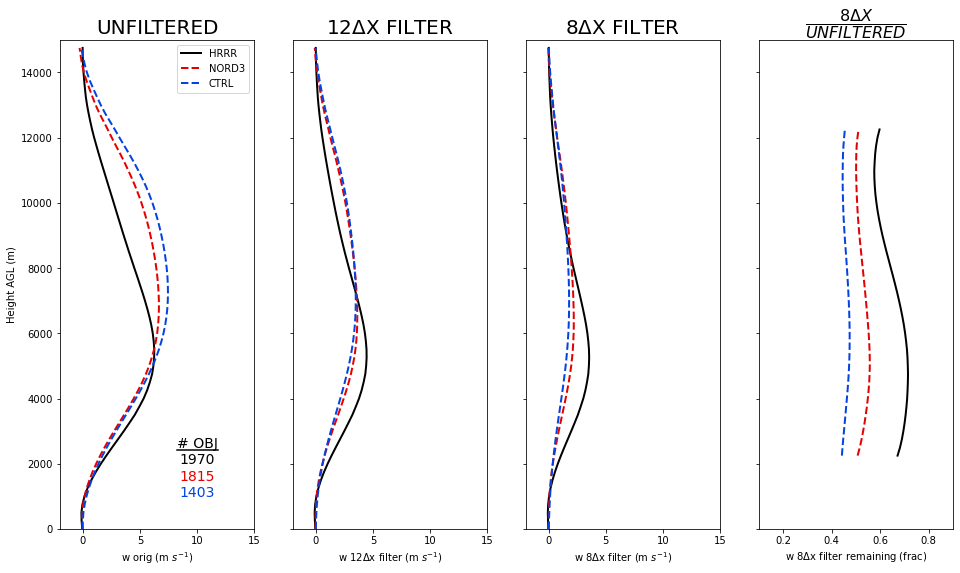

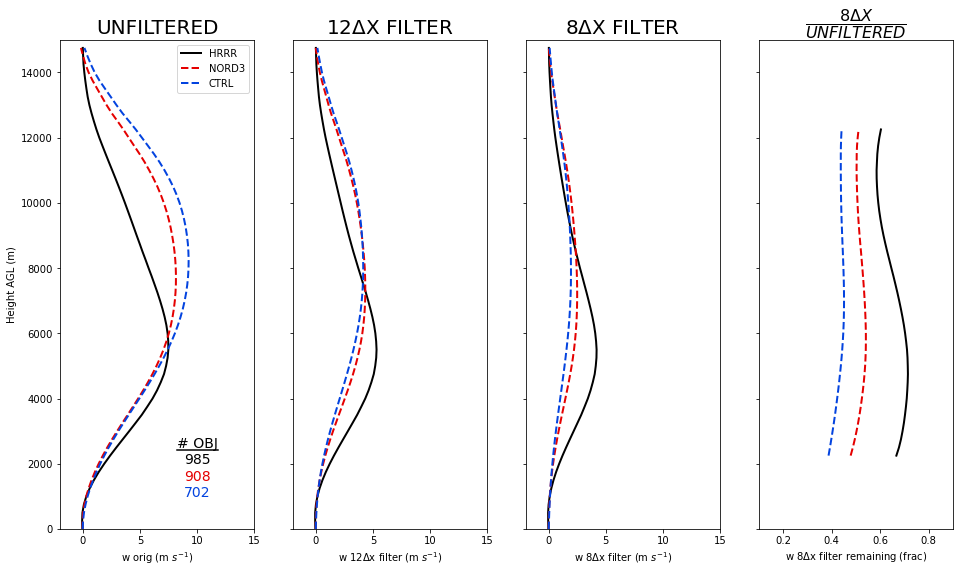

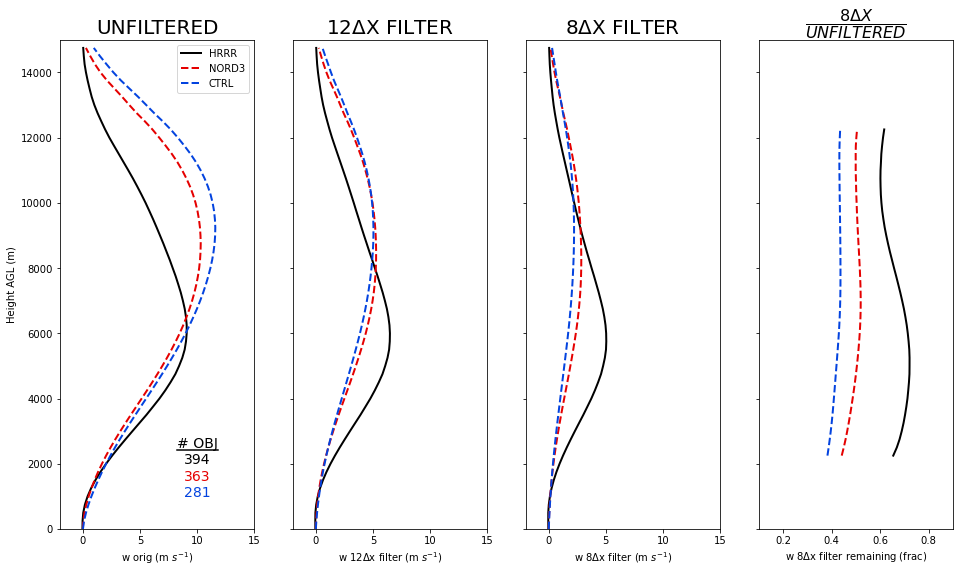

In [16]:
#linecolors=("black","xkcd:blue","xkcd:red")
#linestyles=("-","--","--")
#linewidths=(2,2,2,2)
#th = 2
#w_mean_all = np.stack((fobj.OBJ_W[:,th,...],w_mean_filter[:,1,th,...],w_mean_filter[:,0,th,...]))
#w_objs[g,j,n,i,p,:] day group, oth, filter, time, obj, point, z
#day,group,time,obj,z

#(4,3,60,1800)
threshes = [50,75,90]
print(np.shape(w_objs))
titlefontsize=20
#for oth in np.arange(nth):
oth = 0
wth = wths[oth]
dbzth = dbzths[oth]
for th in np.arange(3):
    fig,ax = plt.subplots(1,4,sharey='row')
    fig.set_size_inches(16,9)
    #z_interp = fobj.height
    #fig.subplots = plt.subplots_adjust(hspace=0.4, wspace=0.4)
    #fig.suptitle(title, fontsize=24)
    #group,time,object
    w_obj_mean = np.reshape(np.moveaxis(np.moveaxis(np.nanmean(w_objs_3plus[:,:,oth,:,:,:,:,:],axis=5),5,3),0,-1),(ng,3,nz,7200)) #group,flt,z, time*nobj
    w_obj_plot = np.nanmax(w_obj_mean[:,0,:,:],axis=1)
    for i in np.arange(ng):
        print('oth %d %s W %d pct = %4.2f'%(oth,group_names[i],threshes[th],w_pct[oth,i,th]))
        w_plot = np.nanmean(w_obj_mean[i,0,:,w_obj_plot[i,:]>w_pct[oth,i,th]],axis=0)
        npts=np.shape(w_obj_mean[i,0,:,w_obj_plot[i,:]>w_pct[oth,i,th]])[0]
        ax[0].plot(w_plot,z_interp,color=linecolors[i],linewidth=linewidths[i],linestyle=linestyles[i],label='{}'.format(group_names[i]))
        ax[0].text(10.0,2000.0-500.0*i,'%i'%npts,color=linecolors[i],fontsize=14,ha='center')
        #ax[0].plot(np.nanmean(fobj.OBJ_W[i,th,...],axis=0),z_interp,color=linecolors[i],linewidth=linewidths[i],linestyle=linestyles[i],label='{}'.format(group_names[i]))

    ax[0].set_xlim((-2.0,15.0))
    ax[0].set_ylim((0,15000))
    ax[0].set_ylabel('Height AGL (m)')
    #ax[0,0].set_xticks(np.arange(0,60,step=12))
    ax[0].set_xlabel('w orig (m $s^{-1}$)')
    ax[0].set_title('UNFILTERED',fontsize=titlefontsize)
    ax[0].legend()


    for i in np.arange(0,ng):
        w_plot = np.nanmean(w_obj_mean[i,1,:,w_obj_plot[i,:]>w_pct[oth,i,th]],axis=0)
        ax[1].plot(w_plot,z_interp,color=linecolors[i],linewidth=linewidths[i],linestyle=linestyles[i])

    ax[1].set_xlim((-2.0,15.0))
    ax[1].set_ylim((0,15000))
    #ax[0,0].set_xticks(np.arange(0,60,step=12))
    ax[1].set_xlabel('w 12$\Delta$x filter (m $s^{-1}$)')
    ax[1].set_title('12$\Delta$X FILTER',fontsize=titlefontsize)

    for i in np.arange(0,ng):
        w_plot = np.nanmean(w_obj_mean[i,2,:,w_obj_plot[i,:]>w_pct[oth,i,th]],axis=0)
        ax[2].plot(w_plot,z_interp,color=linecolors[i],linewidth=linewidths[i],linestyle=linestyles[i])

    ax[2].set_xlim((-2.0,15.0))
    ax[2].set_ylim((0,15000))
    #ax[0,0].set_xticks(np.arange(0,60,step=12))
    ax[2].set_xlabel('w 8$\Delta$x filter (m $s^{-1}$)')
    ax[2].set_title('8$\Delta$X FILTER',fontsize=titlefontsize)


    for i in np.arange(0,ng):
        ax[3].plot(np.nanmean(w_obj_mean[i,1,9:50,w_obj_plot[i,:]>w_pct[oth,i,th]],axis=0)/np.nanmean(w_obj_mean[i,0,9:50,w_obj_plot[i,:]>w_pct[oth,i,th]],axis=0),z_interp[9:50],color=linecolors[i],linewidth=linewidths[i],linestyle=linestyles[i])

    ax[3].set_xlim((0.1,0.9))
    ax[3].set_ylim((0,15000))
    #ax[0,0].set_xticks(np.arange(0,60,step=12))
    ax[3].set_xlabel('w 8$\Delta$x filter remaining (frac)')
    ax[3].set_title('$\dfrac{8\Delta X}{UNFILTERED}$',fontsize=titlefontsize-4)

    fig.canvas.draw()
    mytext = ax[0].text(10.0,2500.0,'# OBJ',fontsize=14,ha='center')
    transf = ax[0].transData.inverted()
    bb = mytext.get_window_extent()
    bb_datacoords = bb.transformed(transf)
    ax[0].plot([bb_datacoords.x0,bb_datacoords.x1],[bb_datacoords.y0,bb_datacoords.y0],color=('black'))

    fig.savefig('%s/%3.1f_W%2.1fDBZ%02dprofiles_filter_noNAM_3+.png'%(top_dir,threshes[th],wth,dbzth),dpi=300)

In [ ]:
outfilename = ("%s/%s_filter_track_data.nc"%(case_dir,date))

new = xr.DataArray( w_mean, dims=['group','time','th','nz'], 
                 coords={"groups": (["group"], np.arange(ng)),
                         "threshes": (["th"], thresh),
                         "times": (["time"], time_list),
                         "height": (["nz"], z_interp) })  
ds_conus = new.to_dataset(name = 'OBJ_W')

ds_conus.attrs['date']       = date
ds_conus.attrs['gridType']   = 'conus'
ds_conus.attrs['DateTime']   = datetime.now().strftime("%Y%m%d_%H:%M:%S")
ds_conus.attrs['TimeStamp']  = datetime.timestamp(datetime.now())

ds_conus.to_netcdf(outfilename, mode='w') 